## Load Dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
# libgomp issue, must import n2 before torch
from n2 import HnswIndex

In [4]:
import sys

sys.path.insert(0, '..')

In [5]:
import os
home_dir = os.getenv('HOME')

https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution

In [6]:
import glob
import csv
from tqdm.auto import tqdm

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
left_id_set = set()
right_id_set = set()
rows_total = 1363 + 3226
clusters_total = 1300

with tqdm(total=rows_total) as pbar:
    with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/Amazon.csv', encoding="latin1") as f:
        for row in csv.DictReader(f):
            row['id'] = id_enumerator[row["id"]]
            row['name'] = row.pop('title')
            row['source'] = 'google'
            row_dict[row['id']] = row
            left_id_set.add(row['id'])
            pbar.update(1)
    
    with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/GoogleProducts.csv', encoding="latin1") as f:
        for row in csv.DictReader(f):
            row['id'] = id_enumerator[row["id"]]
            row['source'] = 'amazon'
            row_dict[row['id']] = row
            right_id_set.add(row['id'])
            pbar.update(1)

In [7]:
true_pair_set = set()

with open(f'{home_dir}/Downloads/Amazon-GoogleProducts/Amzon_GoogleProducts_perfectMapping.csv') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        true_pair_set.add((id_left, id_right))

len(true_pair_set)

1300

In [8]:
from entity_embed.data_utils.utils import id_pairs_to_cluster_mapping_and_dict

cluster_mapping, cluster_dict = id_pairs_to_cluster_mapping_and_dict(true_pair_set)
len(cluster_mapping)

2404

In [9]:
len(cluster_dict)

1105

In [10]:
# TODO: deal with this difference
# from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

# assert len(true_pair_set - cluster_dict_to_id_pairs(cluster_dict)) == 0

In [11]:
cluster_attr = 'cluster_id'
max_cluster_id = max(cluster_mapping.values())

for row_id, row in tqdm(row_dict.items()):
    try:
        row[cluster_attr] = cluster_mapping[row_id]
    except KeyError:
        row[cluster_attr] = max_cluster_id
        max_cluster_id += 1

In [12]:
[row_dict[row_id] for row_id in next(iter(true_pair_set))]

[{'id': 938,
  'description': 'improve your typing skills today! typing instructor deluxe has a progressive design that has been developed for over 19 years. typing instructor deluxe can provide the right lessons tests strengthening exercises practice material and typing games for your skill level. you can even build your own personal typing plan to focus on specific areas you would like to improve. if you think learning has to be all hard work and no fun think again! for beginning to advanced typists kids to adults typing instructor deluxe will motivate you to improve your typing speed and accuracy using a travel theme and exciting typing challenges.educates entertains and motivates: choose from many typing plans or build your ownnavigate easily and choose your typing materialnew! dynamic learning methodsave your results and reports to track progresslearn voice-touch typing (dictation)3 unique travel themescolorful photos and musicten exciting games300+ magazine articles',
  'manufact

## Preprocess

In [13]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [14]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = itertools.islice((s_part[:30] for s_part in default_tokenizer(s)), 0, 30)
    return ' '.join(s_tokens)[:300]

for row in tqdm(row_dict.values()):
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

## Init Data Module

In [15]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [16]:
alphabet = list('0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ')

In [17]:
attr_info_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'semantic_name': {
        'source_attr': 'name',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'semantic_description': {
        'source_attr': 'description',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
        'use_mask': True,
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
        'use_mask': True,
    }
}

In [18]:
from entity_embed import AttrInfoDictParser

row_numericalizer = AttrInfoDictParser.from_dict(attr_info_dict, row_dict=row_dict)
row_numericalizer.attr_info_dict

17:06:50 INFO:For attr=name, computing actual max_str_len
17:06:50 INFO:For attr=name, using actual_max_str_len=26
17:06:50 INFO:For attr=description, computing actual max_str_len
17:06:50 INFO:actual_max_str_len=29 must be pair to enable NN pooling. Updating to 30
17:06:50 INFO:For attr=description, using actual_max_str_len=30
17:06:50 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
17:06:54 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
17:06:57 INFO:For attr=manufacturer, computing actual max_str_len
17:06:57 INFO:actual_max_str_len=15 must be pair to enable NN pooling. Updating to 16
17:06:57 INFO:For attr=manufacturer, using actual_max_str_len=16
17:06:57 INFO:For attr=price, computing actual max_str_len
17:06:57 INFO:For attr=price, using actual_max_str_len=14


{'name': NumericalizeInfo(attr='name', field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', ' '], max_str_len=26, vocab=None, n_channels=8, embed_dropout_p=0.2, use_attention=True, use_mask=True),
 'description': NumericalizeInfo(attr='description', field_type=<FieldType.MULTITOKEN: 'multitoken'>, tokenizer='entity_embed.data_utils.numericalizer.default_tokenizer', alphabet=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '!', '"', '#', '$', '%', '

In [19]:
from entity_embed import LinkageDataModule

train_cluster_len = 200
valid_cluster_len = 200
datamodule = LinkageDataModule(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=50,
    row_batch_size=16,
    train_cluster_len=train_cluster_len,
    valid_cluster_len=valid_cluster_len,
    test_cluster_len=clusters_total - valid_cluster_len - train_cluster_len,
    only_plural_clusters=True,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    random_seed=random_seed
)

## Training

In [20]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    datamodule,
    ann_k=ann_k,
    embedding_size=300
)

In [21]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

max_epochs = 100
early_stop_callback = EarlyStopping(
   monitor='valid_recall_at_0.3',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='max'
)
tb_log_dir = 'tb_logs'
tb_name = 'amzn-googl'
trainer = pl.Trainer(
    gpus=1,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_log_dir, name=tb_name)
)

17:06:58 INFO:GPU available: True, used: True
17:06:58 INFO:TPU available: None, using: 0 TPU cores
17:06:58 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [22]:
trainer.fit(model, datamodule)

17:06:58 INFO:Train pair count: 292
17:06:58 INFO:Valid pair count: 265
17:06:58 INFO:Test pair count: 998
17:07:00 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 13.7 M
1 | losser      | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
4.6 M     Non-trainable params
13.7 M    Total params


1

In [23]:
model.blocker_net.get_signature_weights()

{'name': 0.20203115046024323,
 'description': 0.1646580696105957,
 'semantic_name': 0.18998850882053375,
 'semantic_description': 0.16894105076789856,
 'manufacturer': 0.1401749700307846,
 'price': 0.13420622050762177}

In [24]:
from entity_embed import validate_best

validate_best(trainer)

{'valid_f1_at_0.3': 0.3679092382495948,
 'valid_f1_at_0.5': 0.7686703096539161,
 'valid_f1_at_0.7': 0.7892156862745099,
 'valid_f1_at_0.9': 0.17529880478087648,
 'valid_pair_entity_ratio_at_0.3': 2.350467289719626,
 'valid_pair_entity_ratio_at_0.5': 0.75,
 'valid_pair_entity_ratio_at_0.7': 0.4205607476635514,
 'valid_pair_entity_ratio_at_0.9': 0.053738317757009345,
 'valid_precision_at_0.3': 0.22564612326043737,
 'valid_precision_at_0.5': 0.6573208722741433,
 'valid_precision_at_0.7': 0.8944444444444445,
 'valid_precision_at_0.9': 0.9565217391304348,
 'valid_recall_at_0.3': 0.9956140350877193,
 'valid_recall_at_0.5': 0.9254385964912281,
 'valid_recall_at_0.7': 0.706140350877193,
 'valid_recall_at_0.9': 0.09649122807017543}

## Testing

In [25]:
trainer.test(ckpt_path='best', verbose=False)

17:08:29 INFO:Train pair count: 292
17:08:29 INFO:Valid pair count: 265
17:08:29 INFO:Test pair count: 998


[{'test_f1_at_0.3': 0.1519868156015382,
  'test_f1_at_0.5': 0.4898710865561694,
  'test_f1_at_0.7': 0.6460409019402202,
  'test_f1_at_0.9': 0.2439516129032258,
  'test_pair_entity_ratio_at_0.3': 6.559167750325098,
  'test_pair_entity_ratio_at_0.5': 1.576072821846554,
  'test_pair_entity_ratio_at_0.7': 0.6976592977893368,
  'test_pair_entity_ratio_at_0.9': 0.10273081924577374,
  'test_precision_at_0.3': 0.08227597145122918,
  'test_precision_at_0.5': 0.3292079207920792,
  'test_precision_at_0.7': 0.5740913327120224,
  'test_precision_at_0.9': 0.7658227848101266,
  'test_recall_at_0.3': 0.9952038369304557,
  'test_recall_at_0.5': 0.9568345323741008,
  'test_recall_at_0.7': 0.7386091127098321,
  'test_recall_at_0.9': 0.145083932853717}]

## Testing manually 

In [26]:
# Only call this if test above wasn't run
# datamodule.setup(stage='test')

In [27]:
test_row_dict = datamodule.test_row_dict
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    left_id_set=left_id_set,
    right_id_set=right_id_set,
    batch_size=16
)

In [28]:
embedding_size = model.blocker_net.embedding_size
test_true_pair_set = datamodule.test_true_pair_set

In [29]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

In [30]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 524 ms, sys: 0 ns, total: 524 ms
Wall time: 95.7 ms


In [31]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
)

CPU times: user 728 ms, sys: 5.76 ms, total: 734 ms
Wall time: 131 ms


In [32]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

6.559167750325098

In [33]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_true_pair_set)

(0.08227597145122918, 0.9952038369304557)

In [34]:
false_positives = list(found_pair_set - test_true_pair_set)
len(false_positives)

9258

In [35]:
false_negatives = list(test_true_pair_set - found_pair_set)
len(false_negatives)

4

In [36]:
cos_similarity = lambda a, b: np.dot(a, b)

In [37]:
for (id_left, id_right) in false_negatives[:10]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            row_dict[id_left], row_dict[id_right]
        )
    )

(-0.00040279556,
 {'id': 845,
  'description': "iplaymusic ' s beginner guitar lessons is the first guitar learning program optimized for the mac and video ipod . the software takes advantage of ilife applications resident on today",
  'manufacturer': 'iplaymusic',
  'price': '49 . 99',
  'name': 'iplaymusic beginner guitar lessons for the mac and ipod',
  'source': 'google',
  'cluster_id': 845},
 {'id': 2324,
  'name': "wingnuts 2 : raina ' s revenge",
  'description': 'system requirements : mac os x 10 . 4 + g4 / g5 / intel 800 + mhz cpu 512 mb ram 32 mb video card 950 mb hard drive',
  'manufacturer': '',
  'price': '28 . 99',
  'source': 'amazon',
  'cluster_id': 845})

(0.29577592,
 {'id': 986,
  'description': 'thinking of switching from your program to cubase 4 ? competitive crossgrades * are a good way to switch to a new program without having to pay full price .',
  'manufacturer': 'steinberg ( yamaha )',
  'price': '549 . 99',
  'name': 'cubase 4 competitive crossgrade',
  'source': 'google',
  'cluster_id': 986},
 {'id': 3601,
  'name': 'steinberg cubase studio 4 software - competitive crossgrade music production software',
  'description': 'cubase studio 4 - music production system for mac os x and windows xp - competitive crossgrade cubase studio 4 from steinberg is an audio / midi editor / recorder',
  'manufacturer': '',
  'price': '199 . 99',
  'source': 'amazon',
  'cluster_id': 986})

(0.21371908,
 {'id': 125,
  'description': '',
  'manufacturer': 'compaq computer',
  'price': '0',
  'name': 'compaq comp . rapid deployment pk - flexible lic kit ( 302127 - b21 )',
  'source': 'google',
  'cluster_id': 125},
 {'id': 3231,
  'name': 'hewlett packard 302127 - b21 prol essentials rdp v1 . x 1u flex lic min qty 5',
  'description': 'prol essentials rdp v1 . x 1u flex lic min qty 5',
  'manufacturer': '',
  'price': '119 . 73',
  'source': 'amazon',
  'cluster_id': 125})

(0.2654533,
 {'id': 272,
  'description': 'adobe audition 2 . 0 gives you professional audio mixing results in real time . record mix edit and master digital audio files with powerful tools that bring flexibility and',
  'manufacturer': 'adobe',
  'price': '349',
  'name': 'adobe audition 2 . 0',
  'source': 'google',
  'cluster_id': 272},
 {'id': 3700,
  'name': 'adobe 22011152 audition2 win retail ue 1u',
  'description': 'audition2 win retail ue 1u',
  'manufacturer': '',
  'price': '296 . 2',
  'source': 'amazon',
  'cluster_id': 272})

## t-sne visualization

In [38]:
vis_sample_size = 10

In [39]:
from entity_embed.data_utils.utils import row_dict_to_cluster_dict

test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
test_cluster_dict = row_dict_to_cluster_dict(test_row_dict, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [40]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [41]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=10, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

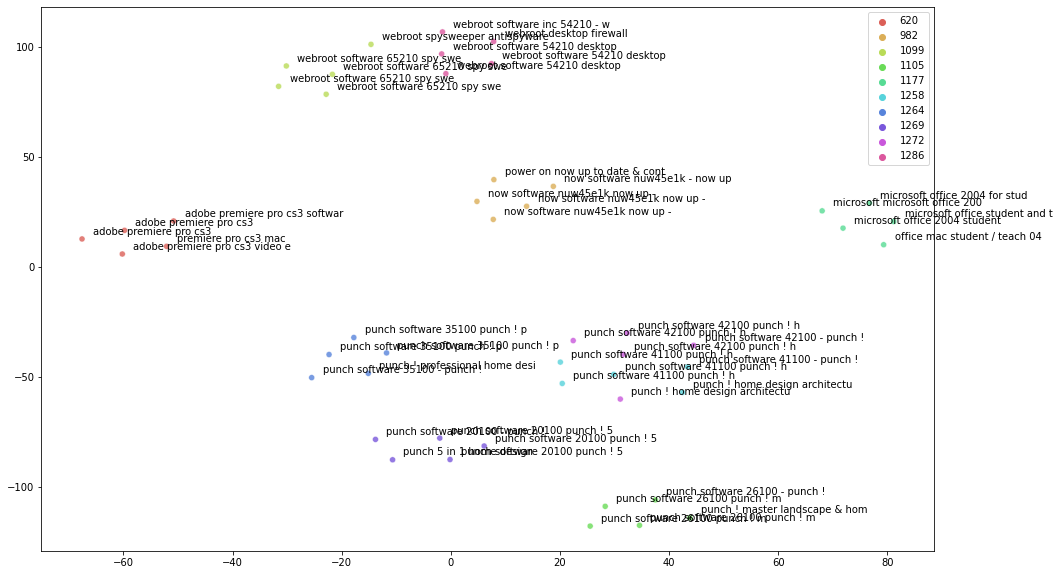

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)